In [1]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum Walks for Finance Part 2: Learnable Quantum Walk in Financial Simulation
$
\renewcommand{\ket}[1]{|{#1}\rangle}
\renewcommand{\bra}[1]{\langle{#1}|}
$

---
## Overview
Efficiently loading classical data into quantum states is a fundamental challenge in quantum computing, underpinning a wide range of applications from quantum machine learning to financial modeling. For instance, encoding a probability distribution such as the historical closing prices of a stock over a fixed time period can be particularly demanding. In this notebook, you will adapt the Discrete Time Quantum Walk into a variational multi-Split Step Quantum Walk, capable of modeling the trading patterns of multiple investors for a specific stock. You will then optimize the walk’s parameters to effectively load the given probability distribution into a quantum state.

**What you'll do:**
* Experiment with the Split Step Quantum Walk (SSQW), which is a generalization of the Discrete Time Quantum Walk (DTQW) introduced in Lab 1.
* Add variational gates for the coin operators to create the multi-Split Step Quantum Walk (mSSQW)
* Use a classical optimizer to identify optimal parameters in the mSSQW that will generate a good approximation to the targeted log-normal probability distribution.

The notebook is organized as follows:
* Section 1: Introduction to the context and problem
* Section 2: Split Step Quantum Walk 
* Section 3: Multi-Split Step Quantum Walk

**Pre-requisites:** Familiarity with discrete time quantum walks, such as the material in [Quantum Walks for Finance Part 1](https://github.com/NVIDIA/cuda-q-academic/quantum-applications-to-finance/01_quantum_walks.ipynb).

🎥 You can [watch a recording of the presentation](https://www.nvidia.com/en-us/on-demand/session/gtcdc25-dct51159/?playlistId=gtcdc25-quantum-computing-and-hpc&start=947&end=3842) of a version of this notebook from a GTC DC tutorial in October 2025.

Let's begin by installing and importing the necessary packages:

In [2]:
## Instructions for Google Colab. You can ignore this cell if you have cuda-q set up and have 
# all the dependent files on your system
# Run this notebook in a CPU runtime
# Uncomment the lines below and execute the cell to install cuda-q

#!pip install cudaq

#!wget -q https://github.com/nvidia/cuda-q-academic/archive/refs/heads/main.zip
#!unzip -q main.zip
#!mv cuda-q-academic-main/quantum-applications-to-finance/images ./images

In [3]:
import cudaq
import numpy as np
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt


We'll reuse some code from [Quantum Walks for Finance Part 1](https://github.com/NVIDIA/cuda-q-academic/quantum-applications-to-finance/01_quantum_walks.ipynb) which we've copied in the code block below. This block contains a helper function for graphing the results of the SSQW and the functions to prevent one-step transitions between the states $\ket{0000}$ and $\ket{1111}$.

Make sure to execute the cell below. 

In [4]:
# Define kernels to prevent transitions between |0000> and |1111>

# Kernel to change a coin from 1 to 0 if the walker is the state |1111>
@cudaq.kernel
def no_INC_at_right_endpoint(walker_qubits : cudaq.qvector, coin_qubit : cudaq.qubit, right_endpoint : cudaq.qubit):
    
    # Test if the coin is in |1> and the walker state is |1111>,  if so, change the end_point qubit to 1
    x.ctrl([coin_qubit, walker_qubits[0], walker_qubits[1], walker_qubits[2], walker_qubits[3]], right_endpoint)
    
    # Flip the state of the coin if the endpoint is triggered
    x.ctrl(right_endpoint, coin_qubit)
    

# Kernel to change a coin from 0 to 1 if the walker is in the state |0000>
@cudaq.kernel
def no_DEC_at_left_endpoint(walker_qubits : cudaq.qvector, coin_qubit : cudaq.qubit, left_endpoint : cudaq.qubit):
    # Bit Flip the walker and coin qubits
    x(coin_qubit)
    x(walker_qubits)
    
    # Trigger the left_endpoint qubit if the walker and the coin are now in the states |1> and |1111> respectively 
    x.ctrl([coin_qubit, walker_qubits[0], walker_qubits[1], walker_qubits[2], walker_qubits[3]], left_endpoint)
    
    # Undo the bit flip on the walker and coin qubits
    x(walker_qubits)
    x(coin_qubit)
    
    # Flip the coin fron |0> to |1> if the endpoint qubit is triggered
    x.ctrl(left_endpoint,coin_qubit)
   
# Kernel to reset the coin and endpoint qubit
@cudaq.kernel()
def reset_coin_and_endpoint(coin_qubit : cudaq.qubit, endpoint: cudaq.qubit):
    # change the coin qubit back if it was flipped to prevent transitions
    # between |0000> and |1111>
    x.ctrl(endpoint, coin_qubit)

    # reset the endpoint qubit to |0>
    reset(endpoint)

Below we've modified some of the code from [Quantum Walks for Finance Part 1](https://github.com/NVIDIA/cuda-q-academic/quantum-applications-to-finance/01_quantum_walks.ipynb)  that we will repurpose here.   In particular, we'll replace the `INC` and `DEC` operations for shifting the walker's position with the kernels `inc` and `dec` that are defined with gate operators as opposed to unitary operators.  The advantage of this approach is that we'll be able to create nested kernels that will simplify the exposition.  The code below works for a 4-qubit walk.  At the end of this lab you'll be tasked with adapting all the code to work for any number of qubits.

In [5]:
# Define a kernel on 4 qubits for the inc operation that
# maps |x> to |x+1> mod 16
num_qubits = 4

@cudaq.kernel
def inc(qubits : cudaq.qview):
    x.ctrl([qubits[3], qubits[2], qubits[1]], qubits[0])
    x.ctrl([qubits[3], qubits[2]], qubits[1])
    x.ctrl(qubits[3], qubits[2])
    x(qubits[3])

# Define a kernel on 4 qubits for the dec operation that
# maps |x> to |x-1> mod 16
@cudaq.kernel
def dec(qubits : cudaq.qview):
    cudaq.adjoint(inc, qubits)    



We also use the helper function  below to plot histograms of the results of the quantum walks. 

In [6]:
def plot_results(result, num_qubits, title):
    """
    Plots a histogram of quantum sampling results.
    
    Args:
        result (dict or cudaq.SampleResult): The counts dictionary (e.g. from get_marginal_counts).
        num_qubits (int): The number of qubits analyzed (determines x-axis states).
    """
    #  Initialize x-axis with all possible bitstrings (0 to 2^N)
    #    This ensures the graph includes states with 0 probability.
    result_dictionary = {}
    for i in range(2**num_qubits):
        bitstr = bin(i)[2:].zfill(num_qubits)
        result_dictionary[bitstr] = 0

    #  Populate with data, robustly cleaning keys
    if hasattr(result, 'items'):
        for bitstr, count in result.items():
            # Robust Fix: Filter to keep ONLY '0' and '1' characters.
            # This removes spaces and invisible null terminators (\x00).
            clean_key = "".join(c for c in str(bitstr) if c in "01")
            
            if clean_key in result_dictionary:
                result_dictionary[clean_key] = count
            else:
                # Useful for debugging if you passed the wrong num_qubits
                print(f"Warning: Key '{clean_key}' ignored (Length {len(clean_key)} "
                      f"!= expected {num_qubits})")

    #  Prepare Lists
    x = list(result_dictionary.keys())
    y = list(result_dictionary.values())

    #  Plot
    plt.figure(figsize=(10, 5))
    plt.bar(x, y, color='#76B900')
    
    plt.title(title)
    plt.xlabel("States")
    plt.ylabel("Counts")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

---
## Introduction to the Context and Problem

### The Context

A significant challenge in quantum computing is the efficient encoding of classical data into quantum states that can be processed by quantum hardware or simulated on classical computers. This is particularly crucial for many financial applications, where the first step of a quantum algorithm often involves efficiently loading a probability distribution. For instance, to enable lenders to price loans more accurately based on each borrower's unique risk profile, it is essential to estimate individual loan risk distributions (such as default and prepayment) while accounting for uncertainties in modeling and macroeconomic factors. Efficiently implementing this process on a quantum computer requires the ability to load a log-normal or other complex distribution into a quantum state [(Breeden and Leonova)](https://www.tandfonline.com/doi/full/10.1080/01605682.2022.2115415).

Financial markets exhibit complex probability distributions and multi-agent interactions that classical models struggle to capture efficiently. Quantum walks can be used to generate probability distributions of market data. The quantum walk approach offers:
* Flexible modeling of price movements
* Better representation of extreme events compared to classical methods
* Ability to capture asymmetric return distributions [(Backer et al)](https://arxiv.org/pdf/2403.19502).


### The Problem 

This tutorial explores the multi-split-step quantum walks (mSSQW) technique, as detailed by [Chang et al.](https://arxiv.org/pdf/2302.12500), to load a specific probability distribution into a quantum state.  Although this technique is applicable to various distributions, our focus here is on the log-normal distribution, which can model the spot price of a financial asset at maturity. In brief, the logarithm of the asset price follows:

$$
\log S_T \sim \mathcal{N} \left( \left( r - \frac{1}{2} \sigma^2 \right) T + \log S_0, \sigma^2 T \right)
$$

Where:
- $S_T$ → Asset price at time T.  
- $S_0$ → Initial asset price.  
- $T$ → Time to maturity (future time period).  
- $r$ → Risk-free interest rate.  
- $\sigma$ → Volatility (measure of price fluctuation).

Below, you will find a graph illustrating the sampling of a continuous log-normal distribution targeted in this tutorial.

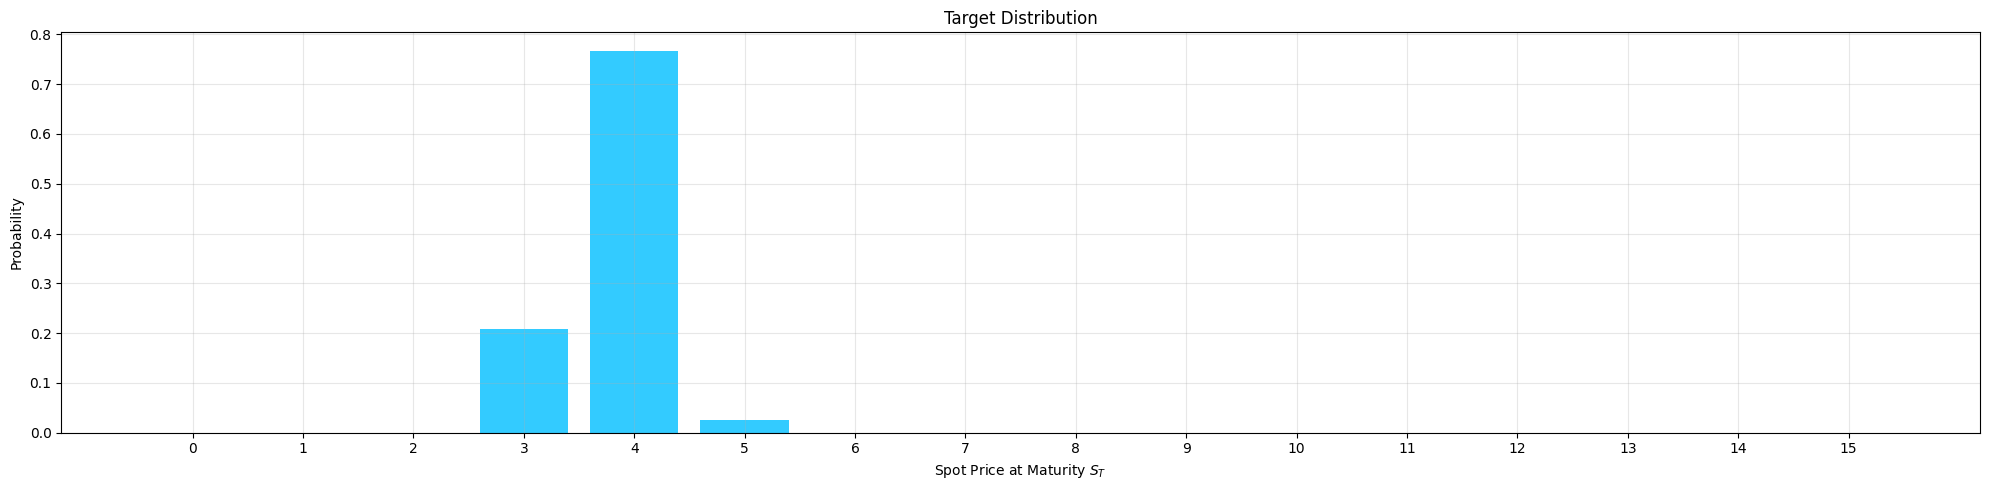

In [7]:
# Prepare data

S = 4.0  # initial spot price
vol = 0.3  # volatility (40%)
r = 0.06  # annual interest rate (4%)
T = 30 / 365  # 90 days to maturity


def prepare_data(S, vol, r, T, N=2**10, num_qubits=4):
    mu = (r - 0.5 * vol**2) * T + np.log(S)
    sigma = vol * np.sqrt(T)
    mean = np.exp(mu + sigma**2 / 2)
    std_dev = np.sqrt((np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2))

    # lowest and highest value considered for the spot price
    low, high = np.maximum(0, mean - 3 * std_dev), mean + 3 * std_dev

    # Sample from the log-normal distribution
    np.random.seed(42)
    log_normal_samples = np.clip(np.round(np.random.lognormal(mean=mu, sigma=sigma, size=N) * 2) / 2, 0, 2**num_qubits)

    # Calculate and return the target distribution from log-normal distribution
    bins = np.arange(2**num_qubits + 1)
    target = np.bincount(log_normal_samples.astype(int), minlength=len(bins) - 1)
    return target / target.sum()


target = prepare_data(S, vol, r, T)

# Plot the target distribution
fig, ax1 = plt.subplots(figsize=(20, 5))  # Increased figure width to accommodate all ticks

# Quantum walk vs. target distribution comparison
x = np.arange(len(target))
ax1.bar(x, target, color='#00BFFF', alpha=0.8)
ax1.set(title='Target Distribution', xlabel='Spot Price at Maturity $S_T$', ylabel='Probability')
ax1.set_xticks(np.arange(len(target)))
ax1.tick_params(axis='x', which='major', labelbottom=True) 
ax1.grid(alpha=0.3)

plt.tight_layout()  # Use this to avoid labels and titles being cut off
plt.show()

---
## Split Step Quantum Walk

The aim of this tutorial is to load the targeted distribution, graphed above, into a quantum state using quantum walks.  Before getting into the details of the mSSQW, let's first define the *[**split-step quantum walk (SSQW)**](https://arxiv.org/pdf/2302.12500)*.

SSQW is an extension of the DTQW introduced in [Part 1 of this series](https://github.com/NVIDIA/cuda-q-academic/quantum-applications-to-finance/01_quantum_walks.ipynb).  For the SSQW, each time step is split into two actions determined by the outcome of two coin flips, hence the name "split step." As was the case in the DTQW, instead of classical coins that can be in the discrete states heads or tails, we use single-qubit quantum state $\ket{\psi_{C}}$ to represent the state of the coin.  

In contrast to the DTQW, the SSQW involves flipping the coin twice for each time step. The first flip determines whether the state of the walker shifts right, and the second flip determines whether the state of the walker shifts left.  That is, we will apply a quantum coinflip operation $F_1$ on $\ket{\psi_{C}}.$ The outcome of this flip $F_1\ket{\psi_{C}}$ will determine whether the walker's state shifts to the right or remains unchanged. Next, during this time step, we apply another, possibly different, quantum operation $F_2$ on the same coin. This outcome $F_2(F_1\ket{\psi_{C}})$ determines whether the walker's state shifts to the left or remains unchanged.  The circuit diagram for one time step of the SSQW algorithm is given below:

<img src="images/SSQW.png" width="400">

Additionally, since our goal is to model financial data, we must avoid scenarios where the walker with one coin flip moves directly between positions $\ket{0000}$ and $\ket{1111}$. Such transitions might suggest an investor with positive sentiment about the stock’s value encoded as $\ket{1111}$ would sell it at a very low price near the value encoded as $\ket{0000}$.  To prevent this, we use an auxiliary qubit `endpoint_qubit` as we did in Part 1. One step of the SSQW with an additional endpoint qubit is depicted as follows:

<img src="images/SSQW_endpoint.png" width="800">



<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px;">
    <h3 style="color: #76b900; margin-top: 0;"> Exercise  1:</h3>
    <p style="font-size: 16px; color: #333;">
Your next exercises is to code one step of the SSQW below using two different coin operations $F_1 = X$ and $F_2 = H$ and disallowing movement of the walker between position $\ket{0000}$ and $\ket{1111}$. 
    </p>
</div>

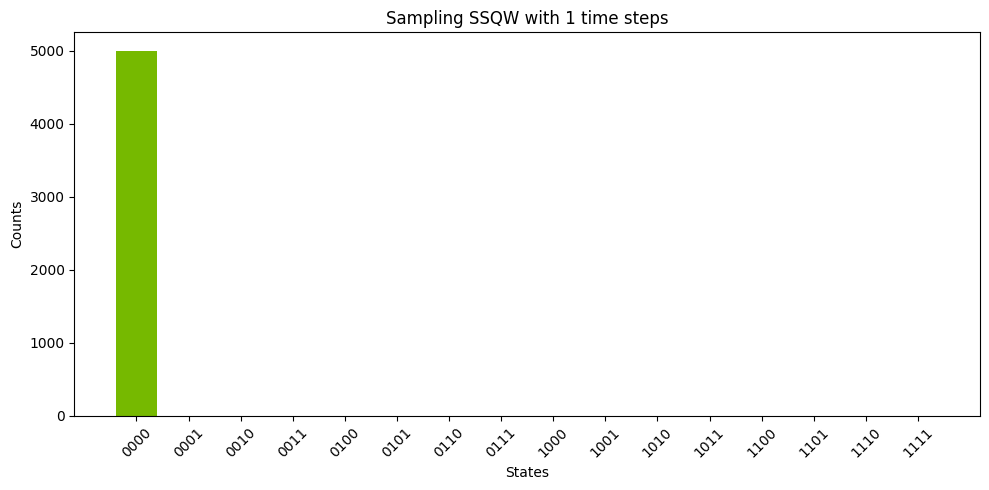

In [8]:
# Set the number of qubits Do Not Change without changing inc and dec
num_qubits = 4

# Set the number of steps
num_time_steps = 1 #CHANGE_ME

# Kernel for one step of the SSQW without measurement
@cudaq.kernel
def SSQW_one_step(walker_qubits : cudaq.qview, coin_qubit : cudaq.qubit, endpoint_qubit : cudaq.qubit):
    
    # One quantum walk step
    
    # First flip of the coin with the first coin operation, F1
    x(coin_qubit)      #CHANGE_ME
    
    # Walker's position change
    # Avoid shifting from |1111> to |0000> in case the coin is |1> by flipping the coin to |0>
    no_INC_at_right_endpoint(walker_qubits, coin_qubit, endpoint_qubit)
    
    # Shift to the right if the coin is |1> and the position is not |1111>
    cudaq.control(inc, coin_qubit, walker_qubits)
    
    # Reset the coin and endpoints in case they were changed to avoid moving from |1111> to |0000>
    reset_coin_and_endpoint(coin_qubit, endpoint_qubit)
    
    
    # Second flip of the coin with the second coin operation, F2
    h(coin_qubit)      #CHANGE_ME
    
    # Controlled-decrementer
    # Avoid shifting from |0000> to |1111> in case the coin is |0> by flipping the coin to |1>
    no_DEC_at_left_endpoint(walker_qubits, coin_qubit, endpoint_qubit)
    
    # Apply the dec if the the coin is in |0>
    x(coin_qubit) 
    cudaq.control(dec, coin_qubit, walker_qubits)
    x(coin_qubit) 
    
    # Reset the coin and endpoints in case they were changed to avoid moving from |0000> to |1111>
    reset_coin_and_endpoint(coin_qubit, endpoint_qubit)
    
@cudaq.kernel()
def SSQW_with_measurement(num_qubits : int, num_time_steps : int):    
    walker_qubits = cudaq.qvector(num_qubits)
    coin_qubit = cudaq.qubit()
    endpoint_qubit = cudaq.qubit()
    
    # Initial walker state 1/sqrt(2)(|1000> + |0000>) #CHANGE_ME
    #h(walker_qubits[0])
    #x(walker_qubits)
    
        
    # Initial coin state    #CHANGE_ME
    x(coin_qubit)
    
    for _ in range(num_time_steps):
        SSQW_one_step(walker_qubits, coin_qubit, endpoint_qubit)
    



#cudaq.draw(SSQW_with_measurement, num_qubits, num_time_steps)

# Sample the kernel for the quantum walk
result = cudaq.sample(SSQW_with_measurement, num_qubits, num_time_steps, shots_count=5000)

# defines indices for walker_qubits_register
walker_register = list(range(0, num_qubits)) 

walker_register_marginal_counts = result.get_marginal_counts(walker_register)


title = 'Sampling SSQW with {} time steps'.format(num_time_steps)
plot_results(walker_register_marginal_counts, num_qubits, title)

Once you've completed the exercise above, feel free to experiment with different combinations of the following:

* initial states of the coin
* initial states of the walker 
* coin operations (e.g., `h`, `t`, `z`, etc.)
* `num_time_steps`

For instance, you might select initial states and coin operators to verify that regardless of the coin, a walker beginning in state $\ket{0000}$ will not move to $\ket{1111}$ in one time step:

<img src="images/SSQW_endpoint_verified.png" width="800">

---
## Multi-Split Step Quantum Walk

As you might have noticed in the previous section, by varying the initial state of the walker and coin, and experimenting with different coin flip operations, we can generate many different distributions.  Another variation to consider is to change the coin operations, $F_1$ and $F_2$, throughout the walk.  For example, perhaps we start with two bit flip operations to change the state of the coin in time step one and then switch to two Hadamard operations on the coin in time step 2.  Go ahead and edit the code block above to observe the newly generated probability distribution.  

The challenge, and the focus of the remainder of this tutorial, is to identify initial states and coins that will generate a targeted probability distribution. To keep things simple, we'll fix the initial states of the coin and the walker. Using parameterized coin operations, we can employ a classical optimizer to iteratively evolve the system to generate the desired distribution.

What we've just described is the ***multi-Split-Step Quantum Walk (multi-SSQW)*** framework, which we have depicted below for a one time step. To adapt this for multiple time steps, the multi-SSQW quantum circuit is replaced with one made up of `num_time_steps` copies of the block sequence of the $k$ investor's split steps.   In a financial application, the different coin operations at each time step can represent distinct investors' decision-making processes reflecting positive or negative sentiments about the value of the stock. The investor's actions can affect a stock price that is being modeled by the probability distribution ([Chang et al.](https://arxiv.org/pdf/2302.12500)).

<img src="images/multi-SSQW_enpoint.png" width="1200">

We've encoded the multi-SSQW circuit below using the [universal three-parameter gate](https://nvidia.github.io/cuda-quantum/latest/api/default_ops.html#u3), `u3`, for the coin flip operators. 

In [9]:
# Initialize the quantum walk kernel and position shift
# Fixed variables do not change 
num_qubits = 4 # Number of qubits representing the state of the walker

# Variables that you can experiment with
num_investors = 2 # Number of investors
num_time_steps = 2 # Number of repetitions of the Investors' walk
shots_count = 100 # increase if runnng on a GPU

@cudaq.kernel
def multiSSQW_kernel(num_qubits: int, num_investors: int, num_time_steps : int, param : list[float]):
    """ kernel for the multi-SSQW circuit for num_investors and num_time_steps
    Parameters
        num_qubits : int
        Number of qubits for the walker's state
        
        num_investors : int
        Number of split-step pairs in one time step
        
        num_time_steps : int
        Number of iterations of the investor's split steps
        
        param : list[float]
        Parameters for the coin operators
    """
    walker_qubits = cudaq.qvector(num_qubits)
    coin_qubit = cudaq.qubit()
    endpoint_qubit = cudaq.qubit()
    # Initial walker state |0101>
    x(walker_qubits[1])
    x(walker_qubits[3])
        
    # Initial coin state (optional)
    u3(param[0], param[1], param[2], coin_qubit)
    
    for _ in range(num_time_steps):    
        # Quantum walk split steps of all the investors
        for k in range(num_investors):
            # Split step of one investor
        
    
            # First coin operation
            u3(param[(k+1)*6-3], param[(k+1)*6-2], param[(k+1)*6-1], coin_qubit)
            
            # Walker's position change
            # Avoid shifting from |1111> to |0000> in case the coin is |1> by flipping the coin to |0>
            no_INC_at_right_endpoint(walker_qubits, coin_qubit, endpoint_qubit)
            # Shift to the right if the coin is |1> and the position is not |1111>
            cudaq.control(inc, coin_qubit, walker_qubits)
    
            # Reset the coin and endpoints in case they were changed to avoid moving from |1111> to |0000>
            reset_coin_and_endpoint(coin_qubit, endpoint_qubit)
    
            
            # Second coin operation
            u3(param[(k+1)*6], param[(k+1)*6+1], param[(k+1)*6+2], coin_qubit)
    
            # Controlled-decrementer
            # Avoid shifting from |0000> to |1111> in case the coin is |0> by flipping the coin to |1>
            no_DEC_at_left_endpoint(walker_qubits, coin_qubit, endpoint_qubit)
    
            # Apply the DEC if the the coin is in |0>
            x(coin_qubit) 
            cudaq.control(dec, coin_qubit, walker_qubits)
            x(coin_qubit) 
    
            # Reset the coin and endpoints in case they were changed to avoid moving from |0000> to |1111>
            reset_coin_and_endpoint(coin_qubit, endpoint_qubit)
        


The code block below defines functions for the classical optimization in the multi-SSQW hybrid workflow. We've selected the COYBLA classical optimizer and the mean square error (MSE) cost function for this example, but other optimizers and cost functions could easily be substituted. 

In [10]:
def quantum_walk_simulation(kernel, num_qubits, num_investors, num_time_steps, param, shots_count=shots_count):
    """
    Execute the multi-SSQW kernel with the given parameters and return probabilities.

    Parameters
        kernel : cudaq.kernel parameterized kernel to be sampled
        num_qubits, num_investors, num_time_steps: parameters defining the kernel
        param : float values for the gate parameters in the kernel
        shots_count : int, number of shots for sampling

    Returns
        probs : list
        A list of float probabilities sorted by bitstring (e.g., [P(00..0), ..., P(11..1)])
    """
    #    Sample the kernel (Measures all qubits by default)
    #    Returns a SampleResult object (dictionary of counts)
    full_result = cudaq.sample(kernel, num_qubits, num_investors, num_time_steps, param, shots_count=shots_count)
    
    #   Extract marginal counts for the first `num_qubits`
    #    This isolates the position register (indices 0 to num_qubits-1)
    #    and discards the states of coin or endpoint qubits.
    target_indices = list(range(num_qubits))
    marginal_counts = full_result.get_marginal_counts(target_indices)

    #    Initialize dictionary with ALL possible bitstrings
    #    This ensures the output list is fully populated (including 0s) and sorted.
    result_dictionary = {}
    for i in range(2**num_qubits):
        bitstr = bin(i)[2:].zfill(num_qubits)
        result_dictionary[bitstr] = 0

    #  Update with actual data from marginal counts
    for bitstr, count in marginal_counts.items():
        # Robust cleanup: remove any potential invisible characters/spaces
        clean_key = "".join(c for c in str(bitstr) if c in "01")
        
        if clean_key in result_dictionary:
            result_dictionary[clean_key] = count

    #   Convert counts to a list of probabilities
    #    Sort by keys to ensure the list order matches the histogram x-axis (000, 001, 010...)
    sorted_keys = sorted(result_dictionary.keys())
    probs = [result_dictionary[key] / shots_count for key in sorted_keys]
    
    return probs


def optimize_distribution(kernel, num_qubits, num_investors, num_time_steps, target, max_iter=100):
    """
    Optimize the quantum walk parameters to match the target distribution
    """
    errors = []
    best_error, best_params = float('inf'), None

    # Define the cost function as a mean square error between the results of the sampling of the kernel 
    # with given parameters and the targeted distribution 
    def cost_function(params):
        trained = quantum_walk_simulation(kernel, num_qubits, num_investors, num_time_steps, params)
        return np.mean((trained - target)**2)

    def callback(xk):
        errors.append(cost_function(xk))

    # Randomly initialize parameters
    random.seed(42)
    x0 = [random.uniform(0, np.pi) for _ in range(6*num_investors + 3)]


    # Optimize
    result = minimize(cost_function, x0=x0, method="COBYLA", options={'maxiter': max_iter}, callback=callback )
    if result.fun < best_error:
        best_error = result.fun
        best_params = result.x

    print(f"Current best error: {best_error}")

    return best_params, errors, best_error

Now, it's time to execute the multi-SSQW and plot the results!

In [11]:
# Define the simulation target
cudaq.set_target("qpp-cpu") #for simulation on CPU 
#cudaq.set_target("nvidia") #for simulation on GPU
# If you run on a GPU, up the shots_count=10000 for a more accurate simulation
# you can also increase the number of iterations to 200

# Optimize to get the final distribution
best_params, errors, final_error = optimize_distribution(multiSSQW_kernel, num_qubits, num_investors, num_time_steps, target)

# Simulate the quantum walk with the best parameters
qw = quantum_walk_simulation(multiSSQW_kernel, num_qubits, num_investors, num_time_steps, best_params)

Current best error: 0.013699371114501953


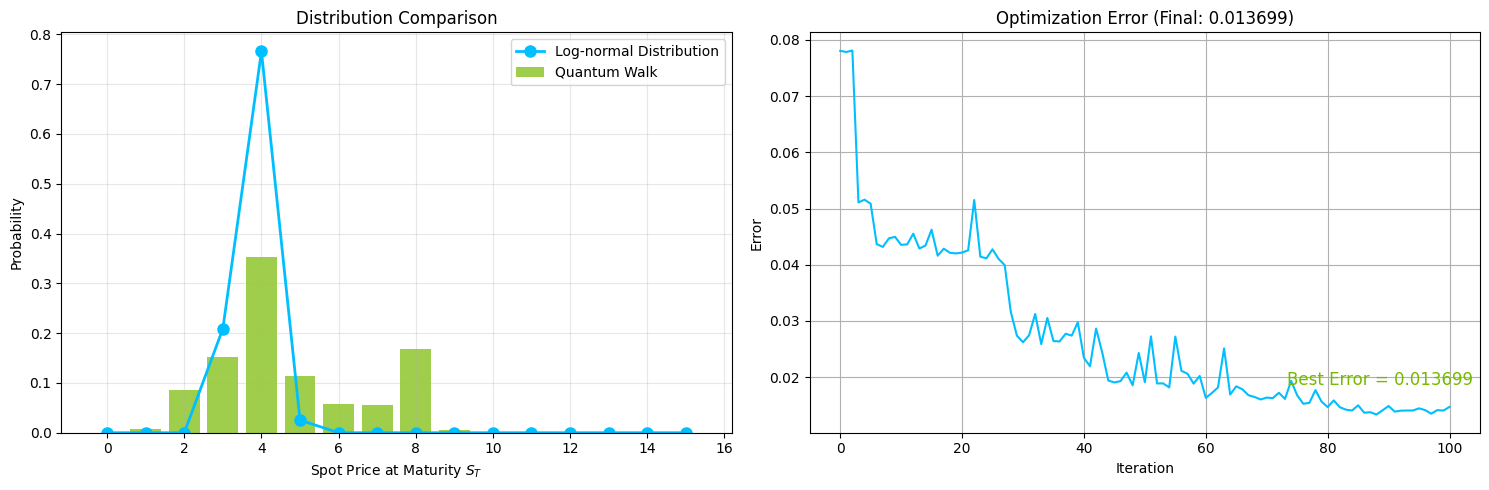

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Quantum walk vs. target distribution comparison
x = np.arange(len(target))
ax1.bar(x, qw, width=0.8, color='#76B900', alpha=0.7, label='Quantum Walk')
ax1.plot(x, target, '-o', color='#00BFFF', linewidth=2, markersize=8, label='Log-normal Distribution')
ax1.set(title='Distribution Comparison', xlabel='Spot Price at Maturity $S_T$', ylabel='Probability')
ax1.grid(alpha=0.3)
ax1.legend()

# Optimization errors plot
ax2.plot(errors, label='Error', color = '#00BFFF')
ax2.set(title=f'Optimization Error (Final: {final_error:.6f})', xlabel='Iteration', ylabel='Error')
ax2.grid(True)
ax2.annotate(f'Best Error = {final_error:.6f}', xy=(len(errors)-1, final_error), xytext=(-50, 20),
             textcoords='offset points', ha='center', fontsize=12, color='#76B900')

plt.tight_layout()
plt.show()

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0;">Challenge:</h3>
    <p style="font-size: 16px; color: #333;">
        Use the multi-split step quantum walk to model other distributions such as stock values over a period of time 
        (you can access historical stock market data using packages such as 
        <a href="https://pypi.org/project/yfinance/" style="color: #76b900; font-weight: bold; text-decoration: underline;">yfinance</a>). 
        You might notice that the success of this approach is very sensitive to the number of steps and the number of walkers. 
        How might you edit the code above to treat these constants as additional parameters that can be optimized? 
        For an even bigger challenge, rewrite the code above to work for an arbitrary number of qubits using the variable 
        <code style="background-color: #e8f5e9; padding: 2px 4px; border-radius: 3px;">num_qubits</code>.
    </p>
</div>


**Future Directions:** Apply what you have learned here to adapt the code to create a [Quantum Walk-Based Adaptive Distribution Generator](https://arxiv.org/pdf/2504.13532) that will allow you to not only model financial data, but also model 2D data such as pixelized images of handwritten digits.